In [2]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

print("Running...")
toc = time.perf_counter()
#ALL SETUP

thr_std=0.2
n_events=9310


E = Events("CheatedRecoFile_1.root")


view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")


u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x


v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

tic = time.perf_counter()
print("All data loaded in", tic-toc, "seconds")

Running...
All data loaded in 186.45882410000002 seconds


In [25]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std, ordering=True):
    #given plane and event number, extract required information and threshold if required
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
        
    if ordering:
        order = np.argsort(AoI_z)
        AoI_z = np.take_along_axis(AoI_z, order, axis=0)
        AoI_x = np.take_along_axis(AoI_x, order, axis=0)
        AoI_adc = np.take_along_axis(AoI_adc, order, axis=0)
        
    AoI = [AoI_z, AoI_x, AoI_adc]
    return AoI, (AoI_truevtxz,AoI_truevtxx)
#AoI, true = AoI("u", 657)
AoI, true = AoI("u", 20)

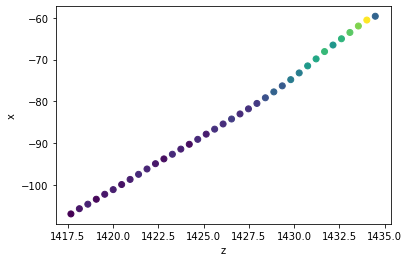

In [26]:
def plotter(AoI, thresholding=True, no_std=thr_std):
    
    AoIz, AoIx, AoIadc = AoI
    
    plt.scatter(AoIz, AoIx, c=AoIadc, cmap="viridis")
    plt.xlabel("z")
    plt.ylabel("x")
plotter(AoI)


In [27]:
def line_finder(AoI, start, pre_scale=10, post_scale=10, wiggle=0.05):
    z, x, adc = AoI #sorted
    
    z, x = np.array(z), np.array(x)
    
    
    
    L = len(z)
    LL = L-1
    
    #make sure search radius behind is suitable
    if (start-pre_scale<0): #if rear view goes behind 0th point
        pre_scale = start        #go back exactly to 0
    
    if (start+post_scale>LL): #if foward view goes beyond largest z value
        post_scale = LL-start          #go only as far as this last value
    
    if pre_scale==0:
        print("ERROR: LEAST Z POINT NON-LINE-ABLE")
        return 0
    if post_scale==0:
        print("ERROR: HIGHEST Z POINT NON-LINE-ABLE")
        return 0
    
    centre = np.array([z[start], x[start]])
    rel_z = z - centre[0]
    rel_x = x - centre[1]
    
    pre_z = rel_z[(start-pre_scale):start]
    pre_x = rel_x[(start-pre_scale):start]
    #x,z coordinates of the pre_scale points immediately before start
    
    post_z = rel_z[(start+1):(start+post_scale+1)]
    post_x = rel_x[(start+1):(start+post_scale+1)]
    #x,z coordinates of the post_scale points immediately after start
    
    pre_theta = np.arctan2(pre_x, pre_z)
    post_theta = np.arctan2(post_x, post_z)
    #angle of all these points relative to z-axis originating at start
    #THETA IS ALWAYS IN RANGE (-pi,pi]
    
    theta_max = (pre_theta + np.pi) + wiggle - 2*np.pi*(pre_theta>0)
    theta_min = theta_max - 2*wiggle
    #bounds of allowed angles for post_theta
    

    
    #START THE LINE
    linestarts = []
    
    for i in range(pre_scale): #for each pre value
        linestart = [[start-i-1, start]]
        add = [w for (w, v) in zip(np.arange(start+1,start+1 + post_scale), ((post_theta>theta_min[i]) & (post_theta<theta_max[i]))) if v]
        linestart.extend(add)
        
        
        
        br = False
        
        for j in linestarts:
            if all(k in j[1:] for k in linestart[1:]):
                j[0].append(start-i-1)
                br = True
                break
        if br:
            break
        linestarts.append(linestart)
        
    


    
    lines = []
    
    for linestart in linestarts:
        ind = linestarts.index(linestart)
        
        pre = linestart[0].copy()
        start = pre.pop(1)
        post = linestart[1:]
        if post==[]:
            continue
        Pl = len(post)
        if Pl==1:
                curr_sec_end = start
        else:
            curr_sec_end = post[-2]
        
        br = False
        while (br == False):
            curr_end = post[-1]

    
            theta0 = np.arctan2(x[curr_end]-x[curr_sec_end], z[curr_end]-z[curr_sec_end])
            curr_sec_end = curr_end
            
            theta_max = theta0 + wiggle
            theta_min = theta0 - wiggle
            theta = np.arctan2(x-x[curr_end], z-z[curr_end])
            for j in range(1,post_scale+1): # compare point i+j to i
                if curr_end+j==L:
                    br = True
                    break
                if (theta_min<theta[curr_end+j]<theta_max):
                    post.append(curr_end+j)
                    break #don't have to break here
                    #this is a sacrifice of speed for technical correctness
                if j==post_scale:#no extension found
                    br = True
        line = []
        for i in pre:
            line.append(i)
        line.append(start)
        for i in post:
            line.append(i)
        lines.append(line)
        
        

    if lines!=[]:
        return lines
    else:
        return None
'''
plotter(AoI)
for qw in range(1,70):
    x = line_finder(AoI, qw)
    print(x)
    if x!= None:
        for i in x:
            plt.plot(AoI[0][i],AoI[1][i], 'ro')
plt.show()
'''

"\nplotter(AoI)\nfor qw in range(1,70):\n    x = line_finder(AoI, qw)\n    print(x)\n    if x!= None:\n        for i in x:\n            plt.plot(AoI[0][i],AoI[1][i], 'ro')\nplt.show()\n"

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]]


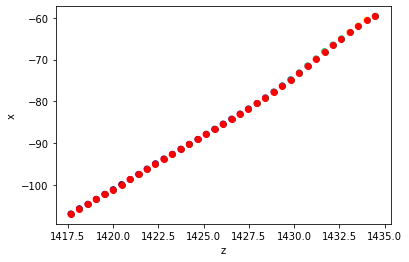

In [29]:
def line_sellotape(AoI, pre_scale=10, post_scale=10, wiggle=0.05):
    ll = len(AoI[0])
    
    lines = []
    for i in range(1,ll-1):
        x = line_finder(AoI, i, pre_scale, post_scale, wiggle)
        if x!=None:
            lines.extend(x)
    
    
    
    lll = len(lines)
    taped_lines = []
    while lll>2:
        line = lines[0]
        discard = []
        for line2 in lines:
            ind2 = lines.index(line2)
            intersect_len = len([el for el in line if el in line2])
            if intersect_len>2:
                line = list(set(line+line2))
                discard.append(line2)
            if ind2==lll-1:
                discard.append(lines[0])
                taped_lines.append(line)
                lines = [linee for linee in lines if linee not in discard]
                lll -= len(discard)
    
    
    
    
    return taped_lines
plotter(AoI)
q = line_sellotape(AoI)
print(q)
for i in q:
    plt.plot(AoI[0][i],AoI[1][i], 'ro')
plt.show()